In [1]:
from constants import *
from phe import best_data
from matplotlib import pyplot as plt
from matplotlib.colors import to_rgba
from matplotlib.patches import ArrowStyle
import pandas as pd

In [2]:
trust_data, _ = best_data(area_type=nhs_trust, metrics=(new_admissions, in_hospital, in_mv_beds))
trust_data

,areaCode,areaName,areaType,date,covidOccupiedMVBeds,hospitalCases,newAdmissions
0,RT5,Leicestershire Partnership NHS Trust,nhsTrust,2021-12-21,0.0,3.0,NaN
1,RT5,Leicestershire Partnership NHS Trust,nhsTrust,2021-12-20,0.0,4.0,NaN
2,RT5,Leicestershire Partnership NHS Trust,nhsTrust,2021-12-19,0.0,7.0,0.0
3,RT5,Leicestershire Partnership NHS Trust,nhsTrust,2021-12-18,0.0,8.0,2.0
4,RT5,Leicestershire Partnership NHS Trust,nhsTrust,2021-12-17,0.0,6.0,1.0
...,...,...,...,...,...,...,...
131916,RAE,Bradford Teaching Hospitals NHS Foundation Trust,nhsTrust,2020-03-23,NaN,2.0,6.0
131917,RAE,Bradford Teaching Hospitals NHS Foundation Trust,nhsTrust,2020-03-22,NaN,4.0,2.0
131918,RAE,Bradford Teaching Hospitals NHS Foundation Trust,nhsTrust,2020-03-21,NaN,3.0,20.0
131919,RAE,Bradford Teaching Hospitals NHS Foundation Trust,nhsTrust,2020-03-20,NaN,1.0,1.0


In [3]:
trust_admissions = trust_data.pivot(index='date', columns='areaName', values=new_admissions)
trust_in_hospital = trust_data.pivot(index='date', columns='areaName', values=in_hospital)

In [4]:
(trust_in_hospital / trust_in_hospital.max()).sum().sort_values()

areaName
Moorfields Eye Hospital NHS Foundation Trust                   0.000000
Wirral Community Health and Care NHS Foundation Trust          0.000000
Leeds Community Healthcare NHS Trust                           0.000000
Cambridgeshire Community Services NHS Trust                    0.000000
Tavistock and Portman NHS Foundation Trust                     0.000000
                                                                ...    
Bolton NHS Foundation Trust                                  201.672840
Newcastle Upon Tyne Hospitals NHS Foundation Trust           203.812121
Tameside and Glossop Integrated Care NHS Foundation Trust    240.244444
Manchester University NHS Foundation Trust                   241.503513
Northern Care Alliance NHS Ft                                246.059140
Length: 212, dtype: float64

<AxesSubplot:xlabel='date'>

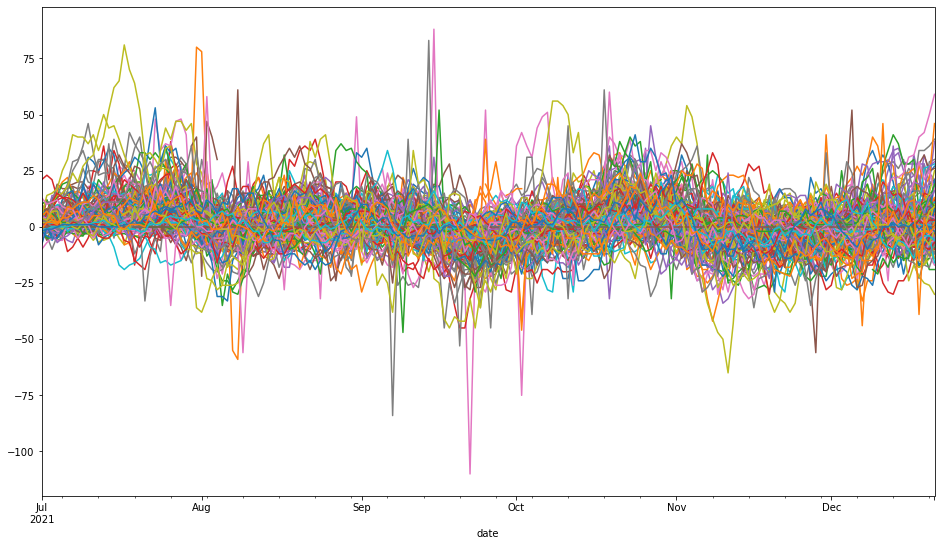

In [5]:
(trust_in_hospital-trust_in_hospital.shift(7)).loc['2021-07':].plot(figsize=(16, 9), legend=False)

<AxesSubplot:xlabel='date'>

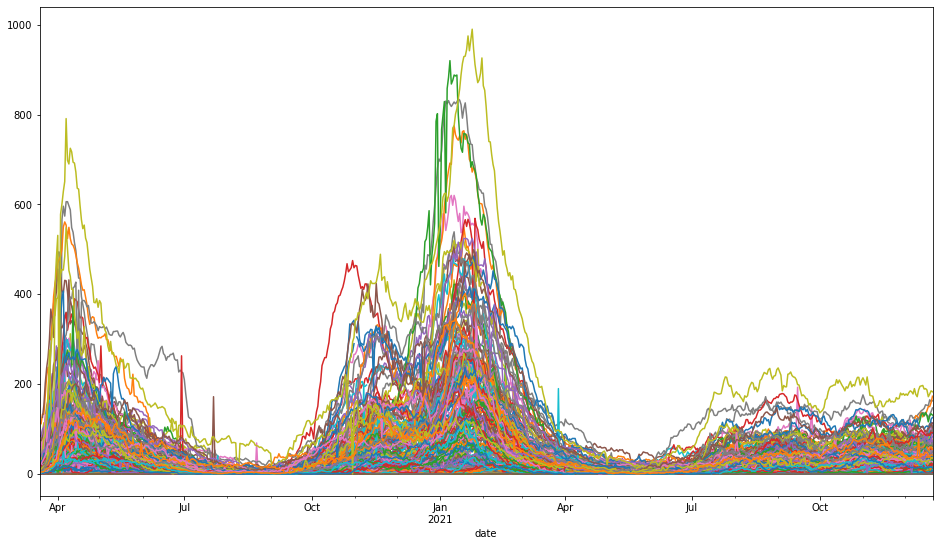

In [6]:
trust_in_hospital.plot(figsize=(16, 9), legend=False)

<AxesSubplot:xlabel='date'>

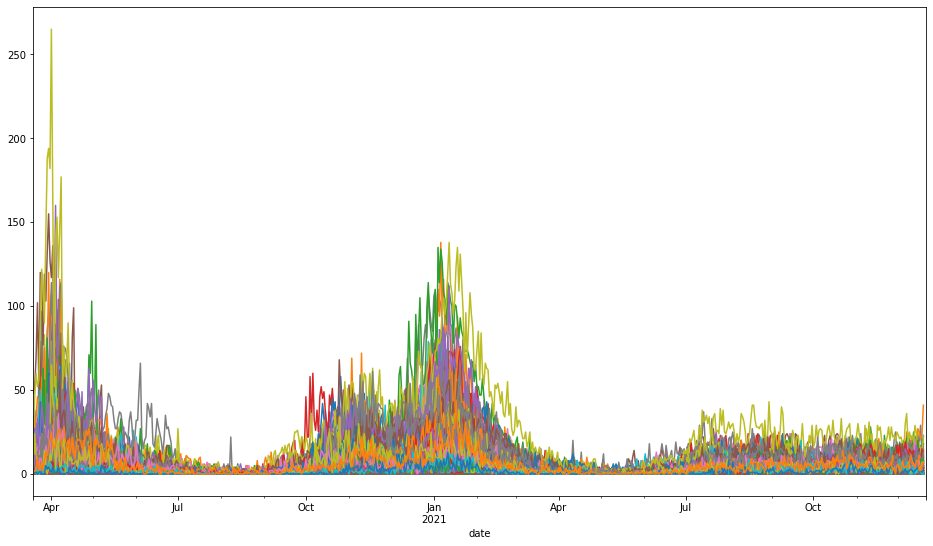

In [7]:
trust_admissions.plot(figsize=(16, 9), legend=False)

In [8]:
region_data, _ = best_data(area_type=nhs_region, metrics=(new_admissions, in_hospital, in_mv_beds))
region_admissions = region_data.pivot(index='date', columns='areaName', values=new_admissions)
region_in_hospital = region_data.pivot(index='date', columns='areaName', values=in_hospital)
region_data

,areaCode,areaName,areaType,date,covidOccupiedMVBeds,hospitalCases,newAdmissions
0,E40000003,London,nhsRegion,2021-12-29,229.0,3310.0,NaN
1,E40000003,London,nhsRegion,2021-12-28,216.0,3024.0,NaN
2,E40000003,London,nhsRegion,2021-12-27,232.0,2640.0,437.0
3,E40000003,London,nhsRegion,2021-12-26,224.0,2425.0,374.0
4,E40000003,London,nhsRegion,2021-12-25,213.0,2295.0,364.0
...,...,...,...,...,...,...,...
4552,E40000010,North West,nhsRegion,2020-03-23,NaN,237.0,86.0
4553,E40000010,North West,nhsRegion,2020-03-22,NaN,190.0,83.0
4554,E40000010,North West,nhsRegion,2020-03-21,NaN,162.0,71.0
4555,E40000010,North West,nhsRegion,2020-03-20,NaN,130.0,56.0


<AxesSubplot:xlabel='date'>

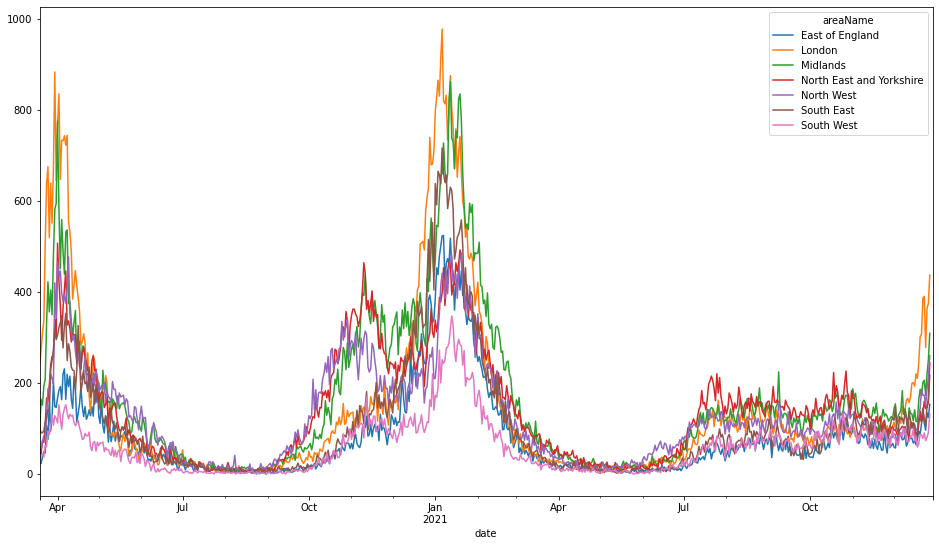

In [9]:
region_admissions.plot(figsize=(16, 9))

<AxesSubplot:xlabel='date'>

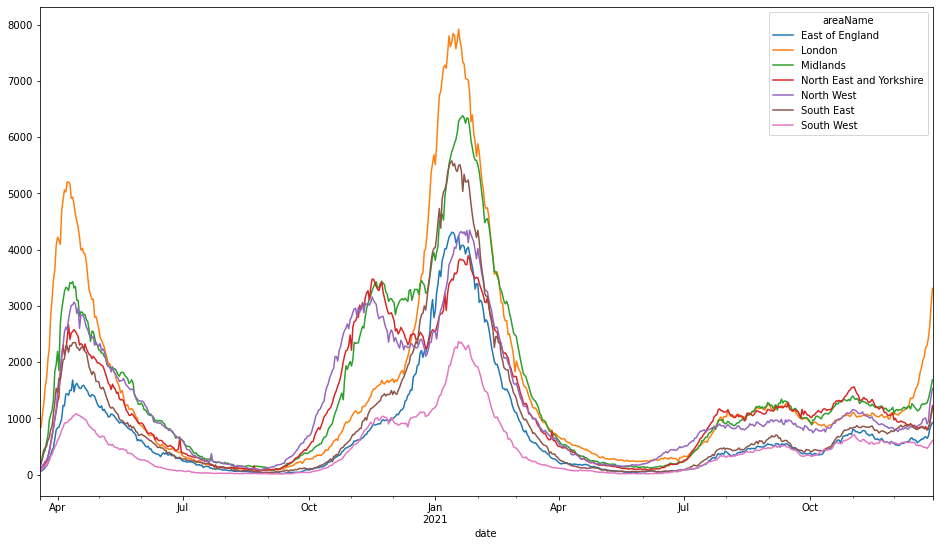

In [10]:
region_in_hospital.plot(figsize=(16, 9))

In [11]:
region_data, _ = best_data(area_type=region, metric=new_cases_by_specimen_date)
region_cases = region_data.pivot(index='date', columns='areaName', values=new_cases_by_specimen_date)
region_data

,areaCode,areaName,areaType,date,cumPeopleVaccinatedCompleteByVaccinationDate,cumPeopleVaccinatedFirstDoseByVaccinationDate,cumPeopleVaccinatedSecondDoseByVaccinationDate,hospitalCases,newCasesBySpecimenDate,newCasesBySpecimenDateRollingRate,newDeaths28DaysByDeathDate,newPeopleVaccinatedCompleteByVaccinationDate,newPeopleVaccinatedFirstDoseByVaccinationDate,newPeopleVaccinatedSecondDoseByVaccinationDate,newVirusTestsBySpecimenDate,uniqueCasePositivityBySpecimenDateRollingSum,uniquePeopleTestedBySpecimenDateRollingSum
0,E12000001,North East,region,2021-12-29,1902948.0,2057124.0,1902948.0,NaN,2149.0,NaN,2.0,1803.0,1057.0,1803.0,NaN,NaN,NaN
1,E12000001,North East,region,2021-12-28,1901145.0,2056067.0,1901145.0,NaN,4945.0,NaN,2.0,1216.0,816.0,1216.0,NaN,NaN,NaN
2,E12000001,North East,region,2021-12-27,1899929.0,2055251.0,1899929.0,NaN,5325.0,NaN,2.0,646.0,417.0,646.0,51890.0,NaN,NaN
3,E12000001,North East,region,2021-12-26,1899283.0,2054834.0,1899283.0,NaN,3592.0,NaN,3.0,81.0,47.0,81.0,52006.0,NaN,NaN
4,E12000001,North East,region,2021-12-25,1899202.0,2054787.0,1899202.0,NaN,1970.0,766.1,1.0,1.0,2.0,1.0,41557.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6533,E12000009,South West,region,2020-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
6534,E12000009,South West,region,2020-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
6535,E12000009,South West,region,2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
6536,E12000009,South West,region,2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84.0,NaN,NaN


In [12]:
region = 'London'
london_cases = region_cases[region].rolling(7).mean().rename('Cases by Specimen Date')
london_hospital = region_in_hospital[region].rename('In Hospital')

Text(0.5, 1.0, 'COVID-19 in London')

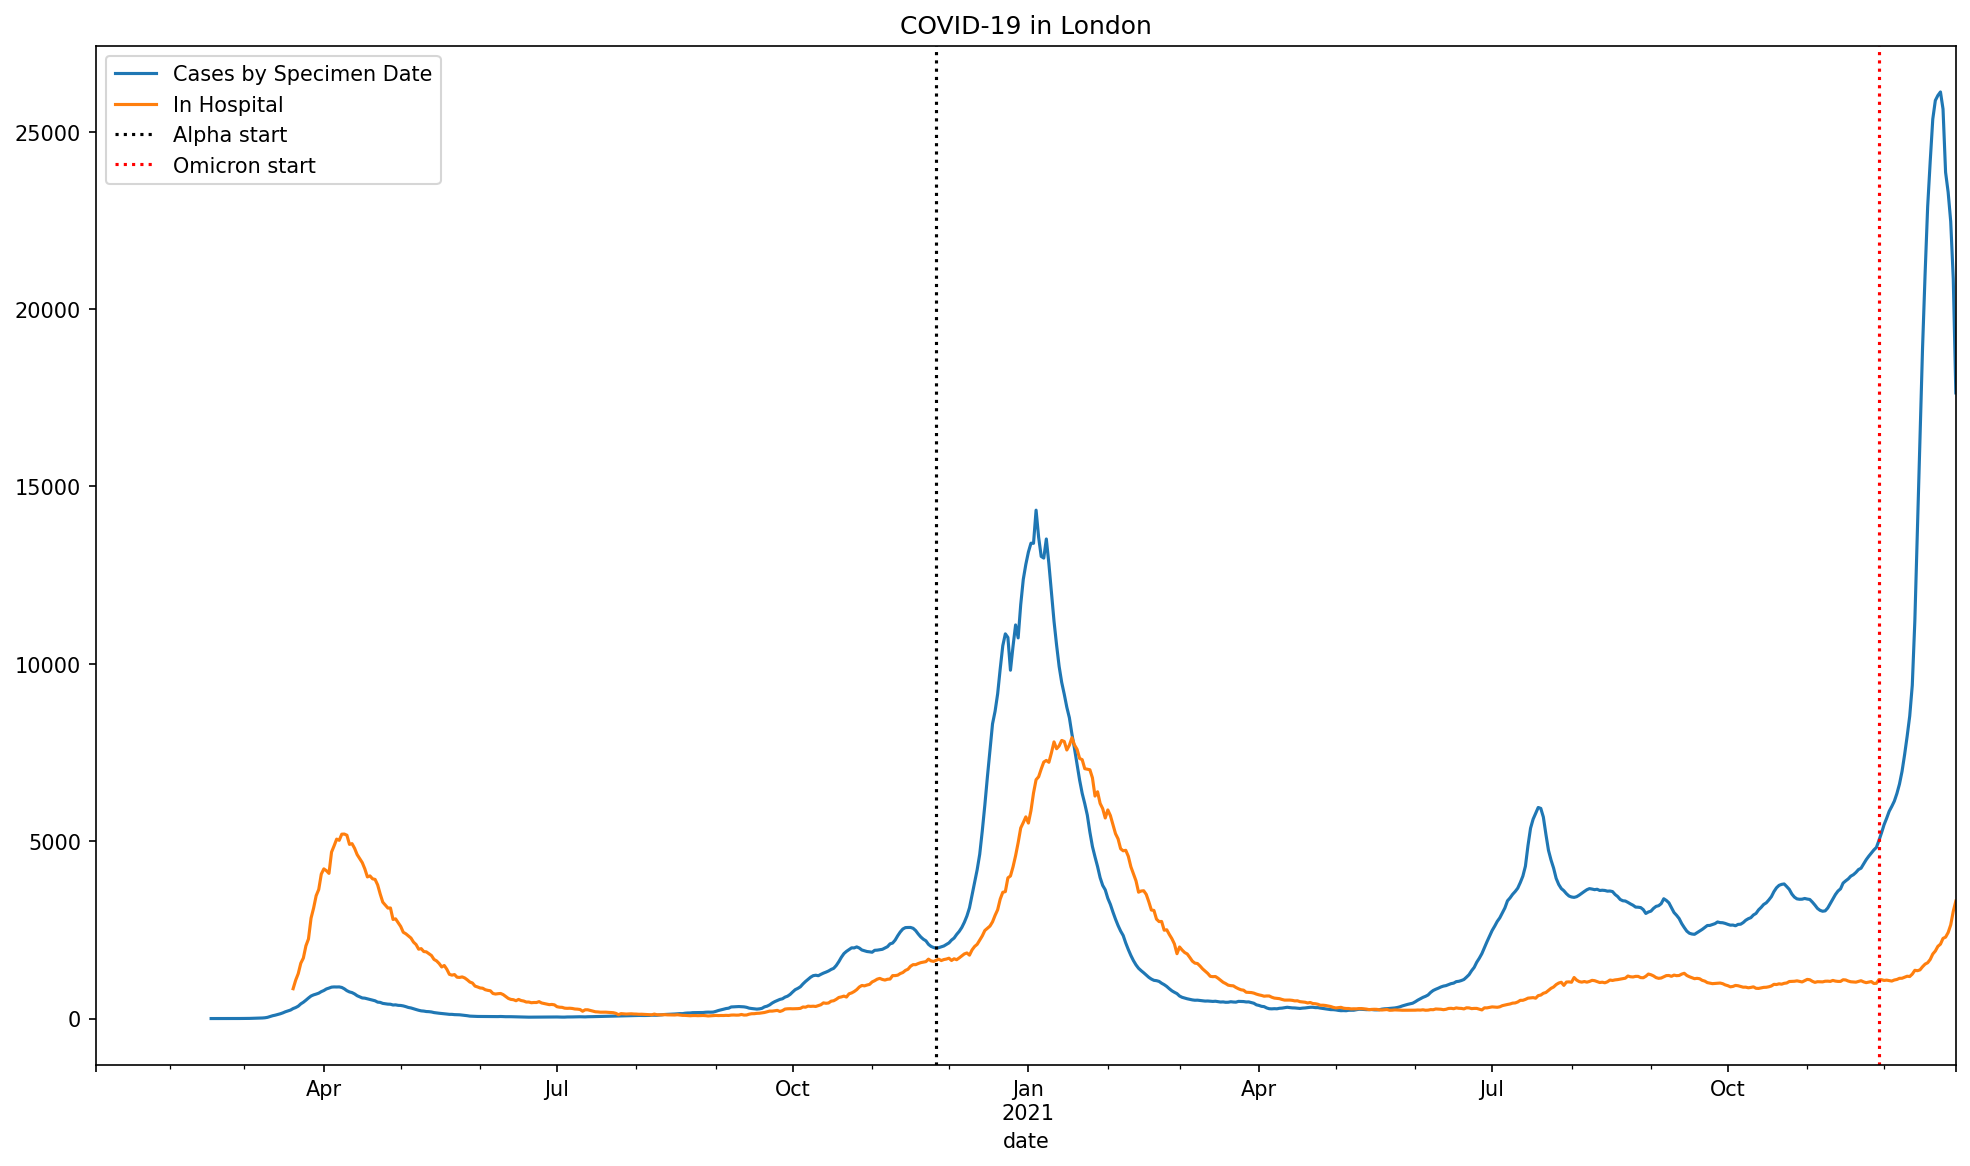

In [13]:
alpha_start = pd.Timestamp('2020-11-26')
omicron_start = pd.Timestamp('2021-11-29')
fig, ax = plt.subplots(figsize=(16, 9), dpi=150)
fig.set_facecolor('white')
london_cases.plot(ax=ax, legend=True)
london_hospital.plot(ax=ax, legend=True)
ax.axvline(alpha_start, label='Alpha start', color='black', linestyle='dotted')
ax.axvline(omicron_start, label='Omicron start', color='red', linestyle='dotted')
ax.legend(loc='upper left')
ax.set_title(f'COVID-19 in {region}')

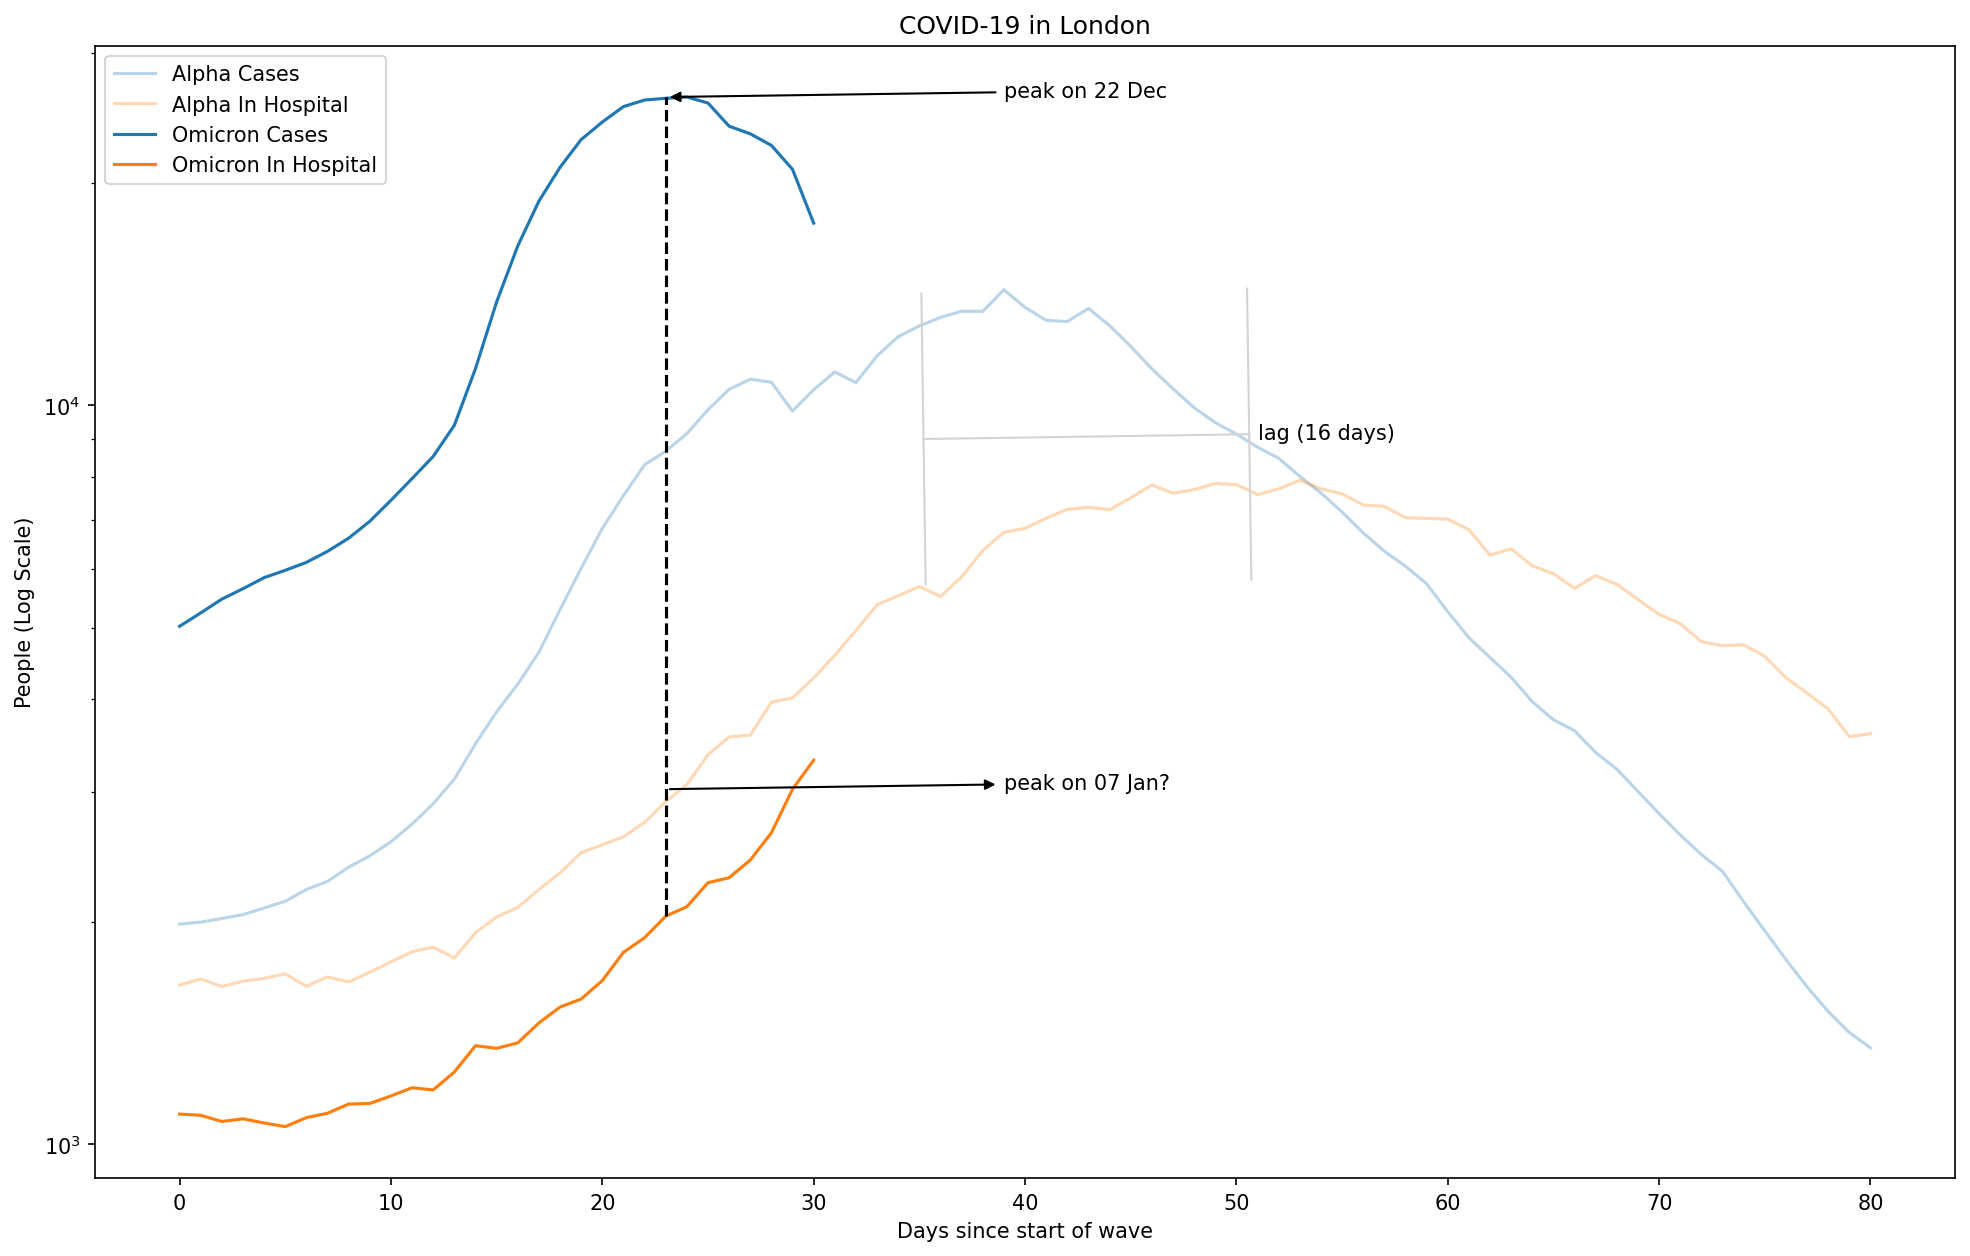

In [43]:
def plot_days_since(ax, data, start, color, label, days=80):
    data = data.copy()
    index = (data.index-start).total_seconds()/60/60/24
    index.name = None
    data.index = index
    data.loc[0:days].plot(ax=ax, color=color, label=label)

def plot_lag(ax, label, x1, x2, *, y, color, arrow):
    ax.annotate(label, xy=(x1, y), xytext=(x2, y), 
                arrowprops=dict(arrowstyle=arrow, color=color))
    
bar = ArrowStyle.BarAB(widthA=7, widthB=7)
arrow_left = ArrowStyle.CurveFilledB()
arrow_right = ArrowStyle.CurveFilledA()

fig, ax = plt.subplots(figsize=(16, 10), dpi=150)
fig.set_facecolor('white')
ax.set_yscale('log')
plot_days_since(ax, london_cases, alpha_start, color=to_rgba('tab:blue', 0.3), label='Alpha Cases')
plot_days_since(ax, london_hospital, alpha_start, color=to_rgba('tab:orange', 0.3), label='Alpha In Hospital')
plot_days_since(ax, london_cases, omicron_start, color='tab:blue', label='Omicron Cases')
plot_days_since(ax, london_hospital, omicron_start, color='tab:orange', label='Omicron In Hospital')
ax.legend(loc='upper left')
plt.xlabel('Days since start of wave')
plt.ylabel('People (Log Scale)')
ax.set_title(f'COVID-19 in London')
x1 = 35
x2 = 51
lag = x2-x1
plot_lag(ax, f'lag ({lag} days)', x1, x2, y=10**4-1000, color='lightgrey', arrow=bar)
omicron_case_peak = 23
omicron_case_peak_dt = omicron_start+pd.Timedelta(days=omicron_case_peak)
omicron_case_peak_label = omicron_case_peak_dt.strftime('peak on %d %b')
x1 = omicron_case_peak
x2 = omicron_case_peak+lag
plot_lag(ax, omicron_case_peak_label, x1, x2, y=london_cases.max(), color='black', arrow=arrow_left)
omicron_hospital_at_case_peak = london_hospital.loc[omicron_case_peak_dt]
omicron_hospital_peak_label = (omicron_case_peak_dt+pd.Timedelta(days=lag)).strftime('peak on %d %b?')
plot_lag(ax, omicron_hospital_peak_label, x1, x2, y=london_hospital.iloc[-2], color='black', arrow=arrow_right)
ax.plot([x1, x1], [omicron_hospital_at_case_peak, london_cases.max()], color='k', linestyle='--')